In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Import and Data Preparation

In [2]:
path = "/content/drive/Shareddrives/DATA 245 - ML/cleaned_SF_crime_report.csv"

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.io.formats.info import DataFrameTableBuilderVerbose
from sklearn.preprocessing import LabelEncoder

In [44]:
df = pd.read_csv(path)
pd.set_option('display.max_columns',None)
df = df.iloc[-200000:,:]

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from tabulate import tabulate

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

In [45]:
# drop columns
df.drop(columns=['Row_ID','Incident_ID','Incident_Number','Report_Type_Code','Report_Type_Description','Filed_Online','Incident_Code',
                'Incident_Subcategory','Incident_Description','Resolution','Report_Datetime','CNN','Police_District'], inplace=True)

In [9]:
# seperate date and time
df['Year'] = df['Incident_Date'].apply(lambda x: int(x[0:4]))
df['Month'] = df['Incident_Date'].apply(lambda x: int(x[5:7]))
df['Day'] = df['Incident_Date'].apply(lambda x: int(x[8:10]))

df['Hour'] = df['Incident_Time'].apply(lambda x: int(x[0:2]))
df['Min'] = df['Incident_Time'].apply(lambda x: int(x[3:5]))

In [10]:
def time_of_day(hour):
    if hour >= 0 and hour < 4:
        return 'Late Night'
    elif hour >= 4 and hour < 6:
        return 'Dawn'
    elif hour >= 6 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 16:
        return 'Afternoon'
    elif hour >= 16 and hour < 20:
        return 'Evening'
    elif hour >= 20 and hour <= 23:
        return 'Night'

In [11]:
def business_hours(hours):
    return 8 <= hours <= 18

In [12]:
def third_of_month(day):
    if day >= 1 and day < 10:
        return '1st_third'
    elif day >= 10 and day < 20:
        return '2nd_third'
    elif day >= 20 and day <= 31:
        return '3rd_third'

In [13]:
def weekend(weekday):
    if weekday == "Saturday" or weekday == "Sunday":
        return True
    else:
        return False

In [14]:
def quarter_of_year(month):
    if month >= 1 and month <= 3:
        return '1st_quarter'
    elif month > 3 and month <= 6:
        return '2nd_quarter'
    elif month > 6 and month <= 9:
        return '3rd_quarter'
    elif month > 9 and month <= 12:
        return '4th_quarter'

In [15]:

df['Time_of_Day'] = df['Hour'].map(time_of_day)
df['Business Hours'] = df['Hour'].map(business_hours)
df['Business Hours'].value_counts()
#df['Third_of_Month'] = df['Day'].map(third_of_month)
df['Weekend'] = df['Incident_Day_of_Week'].map(weekend)
#df['Quarter_of_Year'] = df['Month'].map(quarter_of_year)
df["Incident_Date"] = pd.to_datetime(df["Incident_Date"], format="%Y-%m-%d %H:%M:%S")

cal = calendar()
holidays = cal.holidays(start=df['Incident_Date'].min(), end=df['Incident_Date'].max())
df['Holiday'] = df['Incident_Date'].dt.date.astype('datetime64').isin(holidays)
df.drop(columns = ['Year','Month','Day','Hour','Min','Incident_Date','Incident_Time','Supervisor_District'],inplace=True)
df

,Incident_Day_of_Week,Incident_Category,Analysis_Neighborhood,Latitude,Longitude,Time_of_Day,Business Hours,Weekend,Holiday
354712,Sunday,Warrant,Hayes Valley,37.776159,-122.421148,Morning,False,True,False
354713,Monday,Lost Property,Sunset/Parkside,37.754926,-122.503392,Afternoon,True,False,False
354714,Thursday,Larceny Theft,Lakeshore,37.726950,-122.476039,Evening,False,False,False
354715,Thursday,Weapons Offense,Excelsior,37.718508,-122.435157,Night,False,False,False
354716,Friday,Larceny Theft,Castro/Upper Market,37.768770,-122.427462,Morning,True,False,False
...,...,...,...,...,...,...,...,...,...
554707,Friday,Robbery,Tenderloin,37.785893,-122.412148,Night,False,False,False
554708,Saturday,Larceny Theft,Outer Richmond,37.780476,-122.476169,Evening,True,True,False
554709,Monday,Burglary,Potrero Hill,37.754000,-122.389860,Late Night,False,False,False
554710,Saturday,Larceny Theft,Western Addition,37.777490,-122.433219,Evening,True,True,False


In [16]:
# df_new = df.drop(df[(df['Incident_Category'] != 'Motor Vehicle Theft') & (df['Incident_Category'] != 'Non-Criminal') & (df['Incident_Category'] != 'Assault')
# & (df['Incident_Category'] != 'Burglary') & (df['Incident_Category'] != 'Malicious Mischief') & (df['Incident_Category'] != 'Other Miscellaneous') & (df['Incident_Category'] != 'Larceny Theft')].index)

In [17]:
# df.shape

In [18]:
# df_new.shape

In [19]:
# N = 120000
# df1 = df_new.drop(df_new[df_new['Incident_Category'].eq('Larceny Theft')].sample(N).index)

In [20]:
# df_new.Incident_Category.value_counts()

In [21]:
# df = df_new.copy()

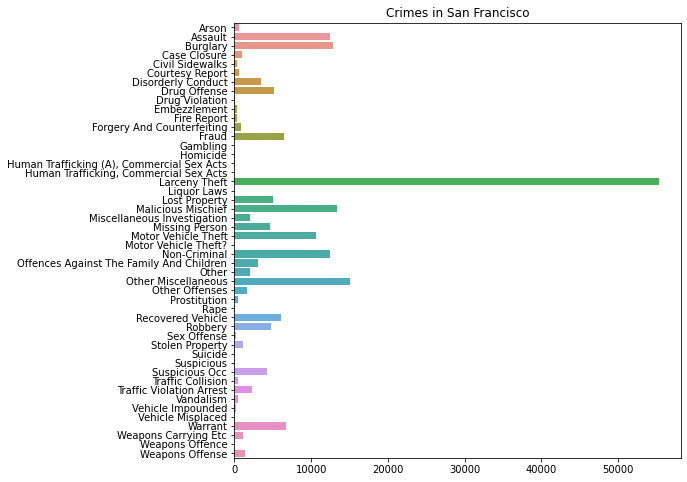

In [22]:

crime, freq = np.unique(df['Incident_Category'],return_counts = True)
fig, count = plt.subplots(figsize = (8,8))
count = sns.barplot(x = freq, y = crime)
count.set_title('Crimes in San Francisco')  
plt.show()

In [23]:
# Reduce the categories       #'Larceny Theft', 'Other Miscellaneous', 'Recovered Vehicle', 'Lost Property', 'Non-Criminal', 'Warrant', Fraud, Burglary

violent = ['Burglary','Malicious Mischief','Assault','Missing Person']
Theft = ['Motor Vehicle Theft', 'Lost Property','Robbery','Larceny Theft']
Other = ['Non-Criminal','Warrant','Fraud','Drug Offense','Suspicious Occ','Other Miscellaneous','Recovered Vehicle']

# Low = ['Recovered Vehicle','Lost Property','Non-Criminal']
# Bad = ['Warrant','Fraud','Assault']

#df.replace(['Beer','Alcohol','Beverage','Drink'],'Drink', inplace=True)  'Larceny Theft',

df.replace(['Burglary','Malicious Mischief','Assault','Missing Person'], 'Violent',inplace=True)
df.replace(['Motor Vehicle Theft', 'Lost Property','Robbery','Larceny Theft'], 'Theft',inplace=True)
df.replace(['Non-Criminal','Warrant','Fraud','Drug Offense','Suspicious Occ','Other Miscellaneous'], 'Other',inplace=True)

In [24]:

df = df.loc[df['Incident_Category'].isin(['Theft','Violent','Other'])]
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df

,Incident_Day_of_Week,Incident_Category,Analysis_Neighborhood,Latitude,Longitude,Time_of_Day,Business Hours,Weekend,Holiday
0,Sunday,Other,Hayes Valley,37.776159,-122.421148,Morning,False,True,False
1,Monday,Theft,Sunset/Parkside,37.754926,-122.503392,Afternoon,True,False,False
2,Thursday,Theft,Lakeshore,37.726950,-122.476039,Evening,False,False,False
3,Friday,Theft,Castro/Upper Market,37.768770,-122.427462,Morning,True,False,False
4,Saturday,Other,Treasure Island,37.827559,-122.373890,Evening,True,True,False
...,...,...,...,...,...,...,...,...,...
171539,Friday,Theft,Tenderloin,37.785893,-122.412148,Night,False,False,False
171540,Saturday,Theft,Outer Richmond,37.780476,-122.476169,Evening,True,True,False
171541,Monday,Violent,Potrero Hill,37.754000,-122.389860,Late Night,False,False,False
171542,Saturday,Theft,Western Addition,37.777490,-122.433219,Evening,True,True,False


In [25]:
#df.to_csv('MLdata.csv')

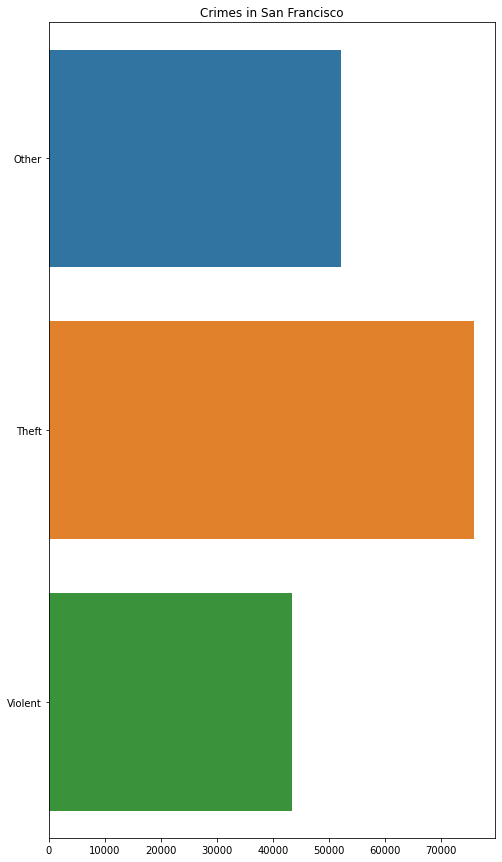

In [26]:
crime, freq = np.unique(df['Incident_Category'],return_counts = True)
fig, count = plt.subplots(figsize = (8,15))
count = sns.barplot(x = freq, y = crime)
count.set_title('Crimes in San Francisco')  
plt.show()

In [27]:
df.head()

,Incident_Day_of_Week,Incident_Category,Analysis_Neighborhood,Latitude,Longitude,Time_of_Day,Business Hours,Weekend,Holiday
0,Sunday,Other,Hayes Valley,37.776159,-122.421148,Morning,False,True,False
1,Monday,Theft,Sunset/Parkside,37.754926,-122.503392,Afternoon,True,False,False
2,Thursday,Theft,Lakeshore,37.726950,-122.476039,Evening,False,False,False
3,Friday,Theft,Castro/Upper Market,37.768770,-122.427462,Morning,True,False,False
4,Saturday,Other,Treasure Island,37.827559,-122.373890,Evening,True,True,False


In [28]:
import warnings
warnings.filterwarnings("ignore")

enc = LabelEncoder()
df['Analysis_Neighborhood'] = enc.fit_transform(df['Analysis_Neighborhood'])
df['Business Hours'] = enc.fit_transform(df['Business Hours'])
df['Holiday'] = enc.fit_transform(df['Holiday'])
df['Incident_Day_of_Week'] = enc.fit_transform(df['Incident_Day_of_Week'])
#df['Quarter_of_Year'] = enc.fit_transform(df['Quarter_of_Year'])
#df['Report_Type_Code'] = enc.fit_transform(df['Report_Type_Code'])
#df['Supervisor_District'] = enc.fit_transform(df['Supervisor_District'])
#df['Third_of_Month'] = enc.fit_transform(df['Third_of_Month'])
df['Weekend'] = enc.fit_transform(df['Weekend'])
df['Incident_Category'] = enc.fit_transform(df['Incident_Category'])

df['Time_of_Day'] = enc.fit_transform(df['Time_of_Day'])

In [29]:
# df.drop(columns=['Analysis_Neighborhood', 'Latitude', 'Longitude', 'Business Hours', 'Incident_Day_of_Week'], inplace = True)
# df.drop(columns=['Business Hours', 'Incident_Day_of_Week'], inplace = True)
df.drop(columns=['Latitude', 'Longitude'], inplace = True)
df.head(50)

,Incident_Day_of_Week,Incident_Category,Analysis_Neighborhood,Time_of_Day,Business Hours,Weekend,Holiday
0,3,0,9,4,0,1,0
1,1,1,34,0,1,0,0
2,4,1,13,2,0,0,0
3,0,1,2,4,1,0,0
4,2,0,36,2,1,1,0
5,4,1,23,3,0,0,0
6,4,1,9,0,1,0,0
7,4,0,18,3,0,0,0
8,1,1,3,2,1,0,0
9,1,1,20,4,1,0,1


# Preprocessing and Modelling

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, matthews_corrcoef
from  sklearn.decomposition import PCA, TruncatedSVD
from imblearn.over_sampling import SMOTE

In [31]:
# Split the data
X = df.loc[:, df.columns != 'Incident_Category']
y = df['Incident_Category']

In [32]:
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)

In [33]:
# np.unique(y,return_counts=True)

In [34]:
# crime, freq = np.unique(y,return_counts = True)
# fig, count = plt.subplots(figsize = (8,5))
# count = sns.barplot(x = freq, y = crime)
# count.set_title('Crimes in San Francisco')  
# plt.show()

In [35]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape

((120080, 6), (51464, 6))

In [36]:
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB

def naive_com(X_train,X_test,y_train,y_test):
  clf = ComplementNB()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  test_acc = accuracy_score(y_pred,y_test)

  y_ptrain = clf.predict(X_train)
  train_acc = accuracy_score(y_ptrain,y_train)
  
  return test_acc, train_acc

def naive_cat(X_train,X_test,y_train,y_test):
  clf = CategoricalNB()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  test_acc = accuracy_score(y_pred,y_test)

  y_ptrain = clf.predict(X_train)
  train_acc = accuracy_score(y_ptrain,y_train)
  
  return test_acc, train_acc

In [37]:
print(naive_cat(X_train,X_test,y_train,y_test))

(0.470348204570185, 0.4745836109260493)


In [38]:
X_train

,Incident_Day_of_Week,Analysis_Neighborhood,Time_of_Day,Business Hours,Weekend,Holiday
110359,2,8,3,0,1,0
10828,6,13,4,1,0,0
162015,6,9,4,1,0,0
47233,2,18,0,1,1,0
33031,3,7,4,1,1,0
...,...,...,...,...,...,...
119879,0,33,5,0,0,0
103694,2,3,0,1,1,0
131932,3,5,0,1,1,0
146867,6,12,4,1,0,0


In [39]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
# define pipeline
steps = [('over', RandomOverSampler()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.434


In [40]:
# fit a logistic regression model on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
# define model
model = LogisticRegression(solver='lbfgs')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: nan


In [41]:
x_subset = X_train[0:20000]
y_subset = y_train[0:20000]

print(np.unique(y_subset))

[0 1 2]


In [42]:
from sklearn.manifold import TSNE
x_train = X_train.iloc[:20000,:]
train_y = y_train[:20000]

(20000, 2)


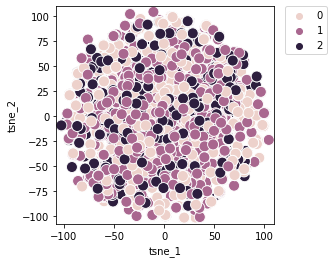

In [43]:
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(x_train)
print(tsne_result.shape)

# # Two dimensions for each of our features
# # Plot the result of our TSNE with the label color coded

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': train_y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0);